In [1]:
import re
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
from sacrebleu import BLEU
from tqdm import tqdm


bleu = BLEU()

In [2]:
df = pd.DataFrame()
for filename in tqdm(glob("translations/*.post.en")):
    beam_size, alpha = re.match(r"translations/beam(\d+)\.alpha(\d+(?:\.\d+)?)\.post.en", filename).groups()
    beam_size = int(beam_size)
    alpha = float(alpha)
    with open(filename) as hypotheses, open("bt_bytepair/data/raw/test.en") as references:
        score = bleu.corpus_score(
            [line.strip() for line in hypotheses],
            [[line.strip() for line in references]],
        )
    df = df.append({
        "beam_size": beam_size,
        "alpha": alpha,
        "bleu": score.score,
        "bp": score.bp,
        "ratio": score.ratio,
        **{
            f"precision_{n}": precision
            for n, precision in enumerate(score.precisions)
        },
    }, ignore_index=True)
df = df.sort_values("beam_size")

100%|██████████| 176/176 [00:04<00:00, 37.25it/s]


In [17]:
df["bleu"].max()

24.170184908801755

In [3]:
alpha0 = df[df.alpha == 0]
alpha0

,beam_size,alpha,bleu,bp,ratio,precision_0,precision_1,precision_2,precision_3
67,1.0,0.0,19.893775,1.000000,1.172662,48.619632,24.778543,14.758698,8.809135
8,2.0,0.0,22.643859,1.000000,1.054471,52.680312,27.802442,17.010309,10.552571
108,3.0,0.0,23.457178,1.000000,1.006423,53.357161,28.270413,17.792252,11.280992
136,4.0,0.0,23.895697,0.963108,0.963772,54.332178,29.590895,18.931686,12.450155
166,5.0,0.0,23.419895,0.906473,0.910586,54.994357,30.913272,19.897959,13.171913
104,6.0,0.0,22.605150,0.875428,0.882580,55.254731,30.834753,19.786973,13.187373
109,7.0,0.0,21.543215,0.828586,0.841727,55.341880,30.871758,20.043764,13.344316
143,8.0,0.0,20.962905,0.793227,0.811922,55.917722,31.578947,20.424159,13.524590
168,9.0,0.0,19.298143,0.765097,0.788798,54.951140,30.778210,19.443111,12.308634
42,10.0,0.0,18.453945,0.715877,0.749486,55.707919,31.071576,19.824017,12.868633


### Graph 1

x: Beam size
y1: BLEU
y2: Brevity Penalty

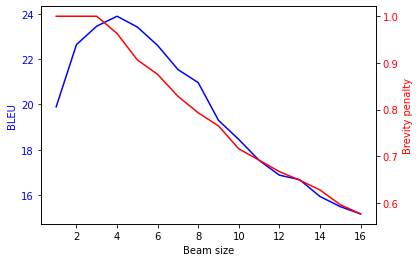

In [4]:
fig, ax1 = plt.subplots(1)
ax1.plot(alpha0["beam_size"], alpha0["bleu"], color="blue")
ax1.set_xlabel("Beam size")
ax1.set_ylabel("BLEU", color="blue")
ax1.tick_params("y", labelcolor="blue")
ax2 = ax1.twinx()
ax2.plot(alpha0["beam_size"], alpha0["bp"], color="red")
ax2.set_ylabel("Brevity penalty", color="red")
ax2.tick_params("y", labelcolor="red")

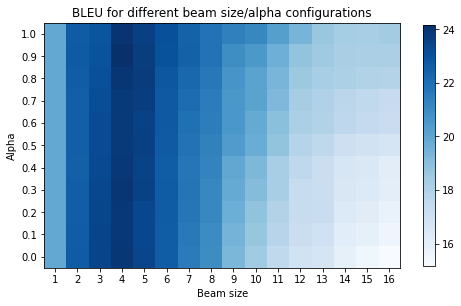

In [16]:
alphabeam = df.pivot(index="beam_size", columns="alpha", values="bleu")
alphabeam = alphabeam.transpose().sort_values("alpha", ascending=False)

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(alphabeam, cmap="Blues")

ax.set_xticks(range(len(alphabeam.columns)))
ax.set_xticklabels([str(int(i)) for i in alphabeam.columns])
ax.set_xlabel("Beam size")


ax.set_yticks(range(len(alphabeam.index.values)))
ax.set_yticklabels([str(i) for i in alphabeam.index.values])
ax.set_ylabel("Alpha")

ax.set_title("BLEU for different beam size/alpha configurations")
fig.tight_layout()
plt.colorbar(im, shrink=0.5)
plt.show()